In [2]:
import caffe
from visualize_weights import vis_square
import matplotlib.pyplot as plt
import numpy as np
import os
% matplotlib inline

To gain more intuition for difficult and easy distinctions, we will visualize the activations of the top layer using PCA.

In [3]:
proto_fn = '/home/mossing/caffemodels_for_alex/even_deeper/fake_prototxt'
param_fn = '/home/mossing/caffemodels_for_alex/even_deeper/snapshot/place_net_iter_50000.caffemodel'
net = caffe.Net(proto_fn, param_fn, caffe.TEST)

In [4]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
mu = np.array([104, 117, 123])
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

As noted previously, rivers were often confused with swamps, hot springs, harbors, and rainforests. We will examine these five categories.

In [17]:
def pca_labels(lbls):
    foldname_list = [name[0]+'/'+name+'/' for name in lbls]
    prefix = 'images/train/'
    D = np.zeros((len(lbls)*1000,1024))
    i=0
    for foldname in foldname_list:
        fnames = os.listdir(prefix+foldname)
        images = [caffe.io.load_image(prefix+foldname+nm) for nm in fnames]
        transformed_images = [transformer.preprocess('data', im) for im in images]
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_images
        ### perform classification
        output = net.forward()
        D[i*1000:(i+1)*1000,:] = net.blobs['fc6'].data
        i=i+1
    u,s,v = np.linalg.svd(D)
    plt.hold(False)
    col = ['r','c','b','m','y']
    for i in range(5):
        plt.scatter(u[i*1000:(i+1)*1000,0],u[i*1000:(i+1)*1000,1],color=col[i],s=1,label=lbls[i])
        plt.hold(True)
    plt.legend()

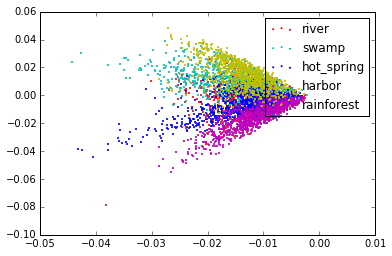

In [110]:
pca_labels(['river', 'swamp', 'hot_spring', 'harbor', 'rainforest'])

Rivers, in red, appear be particularly poorly separated from the other four, right in the middle of them. It turns out that rivers are a fairly diverse category. Here are the first two examples returned by 'os.listdir()':

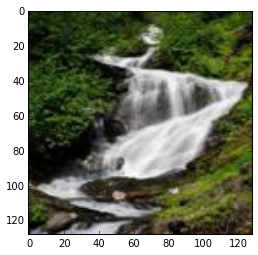

In [16]:
plt.imshow(caffe.io.load_image('images/train/r/river/00000157.jpg'))

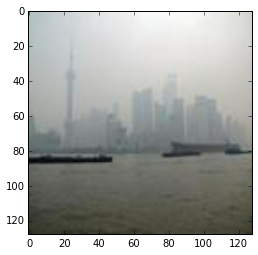

In [12]:
plt.imshow(caffe.io.load_image('images/train/r/river/00000396.jpg'))

For comparison, let's look at an "easier" category, golf courses, and compare it to its most-confused neighbors.

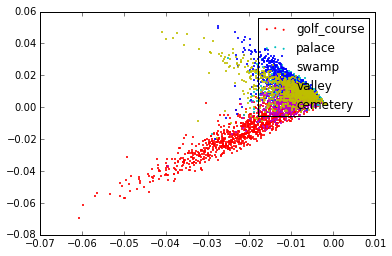

In [19]:
pca_labels(['golf_course', 'palace', 'swamp', 'valley', 'cemetery'])

In contrast to rivers, golf courses seem to be almost linearly separable from their nearest neighbors in the space of top level activations.

#Conclusions

While the errors of the network were semantically meaningful, they did not in general seem to yield intuition for how to optimize the network architecture. Whereas we could name unifying features of a scene category, and the network seems to have "caught on" to them in many cases, it is more difficult to see which network weights are capturing or failing to capture them. That is, the process of changing filter sizes and numbers was guided by overall performance rather than by the details of the previous iteration's errors. We are also curious to know for the future how much improvement could be obtained by using transfer learning.  

Another general comment is that it seems quite hard to make rapid changes to caffe compared with other deep learning programs (at least the documentation is hard to read). For instance, there are a number of other label preserving transformations that one could do in principle such as adjusting the contrast by manipulating the histograms, warping the image, etc. But it is hard to make these changes due to the somewhat rigid structure of adding new layers in caffe. 